In [1]:
# this is to load Javi's python code into my Jupyter notebook
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

import xarray as xr
import requests
#import io
import pandas as pd



In [2]:
# xarray opens the netcdf file

# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")

print(nc)

<xarray.Dataset>
Dimensions:  (ens: 11, ensday: 216, year: 23)
Coordinates:
  * ensday   (ensday) float64 0.0 1.0 2.0 3.0 4.0 ... 212.0 213.0 214.0 215.0
  * year     (year) float64 1.99e+03 1.991e+03 1.992e+03 ... 2.011e+03 2.012e+03
  * ens      (ens) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    rad      (ens, year, ensday) float32 ...
    tmax     (ens, year, ensday) float32 ...
    rain     (ens, year, ensday) float32 ...
    tmin     (ens, year, ensday) float32 ...
Attributes:
    latitude:              -35.99
    longitude:             142.92
    hindcast_start_month:  4.0
    ensemble_members:      11.0


In [3]:
# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header
# I will need the lon and lat later to call exactly the right silo data

start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

print(start_month)
print(lon)
print(lat)

4.0
142.92
-35.99


In [4]:
# Get time bounds properties of the .nc file, which aren't declared attributes

minyear = int(min(nc.year))
maxyear = int(max(nc.year))

print(minyear)
print(maxyear)

1990
2012


In [5]:
# Now we convert the imported netcdf object to a pandas dataframe

ensemble_df = nc.to_dataframe().reset_index()

print(ensemble_df)

        ens  ensday    year        rad       tmax   rain       tmin
0       1.0     0.0  1990.0  19.180000  24.889999   0.00  12.450000
1       1.0     0.0  1991.0  19.230000  25.219999   0.00  12.690000
2       1.0     0.0  1992.0  19.600000  24.889999   0.00  12.680000
3       1.0     0.0  1993.0  19.340000  24.139999   0.00  11.810000
4       1.0     0.0  1994.0  19.820000  25.520000   0.00  13.740000
5       1.0     0.0  1995.0  19.610001  24.520000   0.00  12.390000
6       1.0     0.0  1996.0  19.320000  24.500000   0.00  13.140000
7       1.0     0.0  1997.0  19.180000  24.889999   0.00  13.110000
8       1.0     0.0  1998.0  20.020000  25.840000   0.00  11.850000
9       1.0     0.0  1999.0  19.219999  24.250000   0.00  11.880000
10      1.0     0.0  2000.0  19.639999  25.170000   0.00  11.890000
11      1.0     0.0  2001.0  19.120001  20.969999   0.00   4.580000
12      1.0     0.0  2002.0  19.670000  20.940001   0.00   4.570000
13      1.0     0.0  2003.0  19.520000  21.86000

In [6]:
# now we need to convert all variables to the types that are going to be useful for us to use

ensemble_df["ens"] = ensemble_df["ens"].astype(int)
ensemble_df["ensday"] = ensemble_df["ensday"].astype(int)
ensemble_df["year"] = ensemble_df["year"].astype(int)
ensemble_df["rad"] = round(ensemble_df["rad"].astype(float),1)
ensemble_df["tmax"] = round(ensemble_df["tmax"].astype(float),1)
ensemble_df["rain"] = round(ensemble_df["rain"].astype(float),1)
ensemble_df["tmin"] = round(ensemble_df["tmin"].astype(float),1)

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin
0,1,0,1990,19.2,24.9,0.0,12.4
1,1,0,1991,19.2,25.2,0.0,12.7
2,1,0,1992,19.6,24.9,0.0,12.7
3,1,0,1993,19.3,24.1,0.0,11.8
4,1,0,1994,19.8,25.5,0.0,13.7


In [7]:
#convert the ens column to a string and then convert to two characters
ensemble_df["ens"] = ensemble_df["ens"].astype(str).str.pad(width=2, side='left', fillchar='0')

#convert the ensday column to a string and then convert to three characters
ensemble_df["ensday"] = ensemble_df["ensday"].astype(str).str.pad(width=3, side='left', fillchar='0')

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin
0,01,000,1990,19.2,24.9,0.0,12.4
1,01,000,1991,19.2,25.2,0.0,12.7
2,01,000,1992,19.6,24.9,0.0,12.7
3,01,000,1993,19.3,24.1,0.0,11.8
4,01,000,1994,19.8,25.5,0.0,13.7


In [8]:
# combine the year and the ensemble day into a variable
# this gives us a single identifier for each row of data
# we will use this to join with the silo data
ensemble_df['year_ensday'] = ensemble_df['year'].astype(str) + ensemble_df['ensday']

ensemble_df.head()

,ens,ensday,year,rad,tmax,rain,tmin,year_ensday
0,01,000,1990,19.2,24.9,0.0,12.4,1990000
1,01,000,1991,19.2,25.2,0.0,12.7,1991000
2,01,000,1992,19.6,24.9,0.0,12.7,1992000
3,01,000,1993,19.3,24.1,0.0,11.8,1993000
4,01,000,1994,19.8,25.5,0.0,13.7,1994000


In [9]:
# find the mean of each ensemble variable for each day
# we will only be working with the mean, not each individual ensemble
ensemble_df_mean = ensemble_df.groupby(["year_ensday"]).mean()

ensemble_df_mean.head()

,year,rad,tmax,rain,tmin
year_ensday,,,,,
1990000,1990,18.300000,24.218182,0.009091,9.881818
1990001,1990,17.000000,24.009091,0.009091,9.218182
1990002,1990,15.990909,24.300000,0.218182,9.154545
1990003,1990,17.518182,24.463636,0.000000,9.763636
1990004,1990,16.890909,25.772727,0.018182,10.963636


In [10]:
# rename all variables to reflect they are from access-s ensemble data
# convert all variables to the types that are going to be useful for us to use
# restrict the number to one decimal number

ensemble_df_mean["ens_rad"] = round(ensemble_df_mean["rad"].astype(float),1)
ensemble_df_mean["ens_tmax"] = round(ensemble_df_mean["tmax"].astype(float),1)
ensemble_df_mean["ens_rain"] = round(ensemble_df_mean["rain"].astype(float),1)
ensemble_df_mean["ens_tmin"] = round(ensemble_df_mean["tmin"].astype(float),1)

ensemble_df_mean.head()

,year,rad,tmax,rain,tmin,ens_rad,ens_tmax,ens_rain,ens_tmin
year_ensday,,,,,,,,,
1990000,1990,18.300000,24.218182,0.009091,9.881818,18.3,24.2,0.0,9.9
1990001,1990,17.000000,24.009091,0.009091,9.218182,17.0,24.0,0.0,9.2
1990002,1990,15.990909,24.300000,0.218182,9.154545,16.0,24.3,0.2,9.2
1990003,1990,17.518182,24.463636,0.000000,9.763636,17.5,24.5,0.0,9.8
1990004,1990,16.890909,25.772727,0.018182,10.963636,16.9,25.8,0.0,11.0


In [11]:
# drop the columns that won't be used in the analysis

ensemble_df_mean = ensemble_df_mean.drop(columns="year")
ensemble_df_mean = ensemble_df_mean.drop(columns="rad")
ensemble_df_mean = ensemble_df_mean.drop(columns="tmax")
ensemble_df_mean = ensemble_df_mean.drop(columns="rain")
ensemble_df_mean = ensemble_df_mean.drop(columns="tmin")

print(ensemble_df_mean)

             ens_rad  ens_tmax  ens_rain  ens_tmin
year_ensday                                       
1990000         18.3      24.2       0.0       9.9
1990001         17.0      24.0       0.0       9.2
1990002         16.0      24.3       0.2       9.2
1990003         17.5      24.5       0.0       9.8
1990004         16.9      25.8       0.0      11.0
1990005         13.8      25.1       0.7      11.1
1990006         14.7      24.7       0.9      11.2
1990007         13.9      24.0       0.8      10.2
1990008         15.2      22.7       0.6       7.9
1990009         16.6      23.3       0.0       8.9
1990010         15.2      24.0       0.1       9.1
1990011         16.5      23.0       0.0       8.4
1990012         14.4      23.4       0.0      10.6
1990013         12.8      24.4       2.9      11.2
1990014         13.2      23.4       0.2       9.9
1990015         14.0      22.5       0.2       9.3
1990016         12.9      21.4       2.2       8.8
1990017         13.7      22.1 

In [12]:
# Get SILO data to compare ensemble with it
# this is using the lat and lon we extracted from the attributes in the ensemble data
# Set SILO url download link (specifying csv format)

silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
print(silourl)

https://dcdp.research.csiro.au/silogrid?lat=-35.99&lon=142.92 &format=csv&start=19900101&stop=20121231


In [13]:
# Download SILO data
# the response needs to be 200 - 500 is an error
httpreq = requests.get(silourl, verify=False)

print(httpreq)

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


<Response [200]>


In [14]:
import io

# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas
# In computing, input/output or I/O (or, informally, io or IO) is the communication between an information processing system, 
# such as a computer, and the outside world, possibly a human or another information processing system.

silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))

silo_df.head()

,date,rad,tmax,tmin,rain,vp
0,-,MJ/m^2,oC,oC,mm,hPa
1,1990-01-01,32.10,32.60,15.60,0.00,13.20
2,1990-01-02,28.60,38.10,12.80,0.00,11.90
3,1990-01-03,29.70,43.10,20.20,0.00,7.70
4,1990-01-04,31.80,27.00,11.50,0.00,10.70


In [15]:
# This is to remove the second header row. 
# The first header row contains the names 
# and the second contains the units, which we don't need for our tables. 

silo_df = silo_df.iloc[1:]

silo_df.head()

,date,rad,tmax,tmin,rain,vp
1,1990-01-01,32.10,32.60,15.60,0.00,13.20
2,1990-01-02,28.60,38.10,12.80,0.00,11.90
3,1990-01-03,29.70,43.10,20.20,0.00,7.70
4,1990-01-04,31.80,27.00,11.50,0.00,10.70
5,1990-01-05,25.50,30.00,14.30,0.00,11.10


In [16]:
# Set columns to correct format

silo_df["date"] = silo_df["date"].astype(str)

In [17]:
# import the regex library which is called re
import re

# the ensemble_df has days from April 1st to November 2nd (!!???) each year - a total of 216 days.
# to be able to compare the two data frames it is necessary to crop the silo_df so that it has the same days
# we use regex to do this

silo216_df = silo_df[silo_df['date'].str.contains(r'....-04-..|....-05-..|....-06-..|....-07-..|....-08-..|....-09-..|....-10-..|....-11-01|....-11-02')]

silo216_df.head()

,date,rad,tmax,tmin,rain,vp
91,1990-04-01,20.30,23.90,8.00,0.00,11.50
92,1990-04-02,20.10,22.40,11.10,0.00,11.00
93,1990-04-03,20.10,26.00,8.40,0.00,11.20
94,1990-04-04,19.00,28.30,13.00,0.00,13.70
95,1990-04-05,19.00,29.10,14.00,0.00,14.40


In [18]:
import datetime

# first convert date string to datetime with a proper format string

df = pd.DataFrame({'Date':pd.to_datetime(silo216_df['date'], format='%Y-%m-%d')})


In [19]:
# calculate day of year
# subtract 91 to start at the 1st of April

silo216_df['DOY'] = df['Date'].dt.dayofyear - 91


silo216_df.head()

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date,rad,tmax,tmin,rain,vp,DOY
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,0
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,1
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,2
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,3
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4


In [20]:
# split the date column into year, month and day
# use the hyphen as the split 

silo216_df = silo216_df.join(silo216_df['date'].str.split('-', 2, expand=True).rename(columns={0:'year', 1:'month', 2:'day'}))

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,DOY,year,month,day
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,0,1990,04,01
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,1,1990,04,02
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,2,1990,04,03
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,3,1990,04,04
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,4,1990,04,05


In [21]:
# this makes the day of the year into a three character string

silo216_df["DOY"] = silo216_df["DOY"].astype(str).str.pad(width=3, side='left', fillchar='0')
silo216_df.head()

,date,rad,tmax,tmin,rain,vp,DOY,year,month,day
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,000,1990,04,01
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,001,1990,04,02
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,002,1990,04,03
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,003,1990,04,04
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,004,1990,04,05


In [22]:
# join the year and DOY columns

silo216_df['year_ensday'] = silo216_df['year'].astype(str) + silo216_df['DOY']


In [23]:
# rename all variables to reflect they are from silo data
# round the variables to one decimal point

silo216_df["silo_rad"] = round(silo216_df["rad"].astype(float),1)
silo216_df["silo_tmax"] = round(silo216_df["tmax"].astype(float),1)
silo216_df["silo_rain"] = round(silo216_df["rain"].astype(float),1)
silo216_df["silo_tmin"] = round(silo216_df["tmin"].astype(float),1)

silo216_df.head()

,date,rad,tmax,tmin,rain,vp,DOY,year,month,day,year_ensday,silo_rad,silo_tmax,silo_rain,silo_tmin
91,1990-04-01,20.30,23.90,8.00,0.00,11.50,000,1990,04,01,1990000,20.3,23.9,0.0,8.0
92,1990-04-02,20.10,22.40,11.10,0.00,11.00,001,1990,04,02,1990001,20.1,22.4,0.0,11.1
93,1990-04-03,20.10,26.00,8.40,0.00,11.20,002,1990,04,03,1990002,20.1,26.0,0.0,8.4
94,1990-04-04,19.00,28.30,13.00,0.00,13.70,003,1990,04,04,1990003,19.0,28.3,0.0,13.0
95,1990-04-05,19.00,29.10,14.00,0.00,14.40,004,1990,04,05,1990004,19.0,29.1,0.0,14.0


In [24]:
# get rid of the columns that we don't need to use

silo216_df = silo216_df.drop(columns="rad")
silo216_df = silo216_df.drop(columns="tmax")
silo216_df = silo216_df.drop(columns="tmin")
silo216_df = silo216_df.drop(columns="rain")
silo216_df = silo216_df.drop(columns="date")
silo216_df = silo216_df.drop(columns="month")
silo216_df = silo216_df.drop(columns="day")
silo216_df = silo216_df.drop(columns="year")
silo216_df = silo216_df.drop(columns="DOY")
silo216_df = silo216_df.drop(columns="vp")

silo216_df.head()

,year_ensday,silo_rad,silo_tmax,silo_rain,silo_tmin
91,1990000,20.3,23.9,0.0,8.0
92,1990001,20.1,22.4,0.0,11.1
93,1990002,20.1,26.0,0.0,8.4
94,1990003,19.0,28.3,0.0,13.0
95,1990004,19.0,29.1,0.0,14.0


In [25]:
#join the two dataframes together to perform analyses

fcast_vs_obs = pd.merge(ensemble_df_mean, silo216_df, on ='year_ensday')
fcast_vs_obs.head() 

,year_ensday,ens_rad,ens_tmax,ens_rain,ens_tmin,silo_rad,silo_tmax,silo_rain,silo_tmin
0,1990000,18.3,24.2,0.0,9.9,20.3,23.9,0.0,8.0
1,1990001,17.0,24.0,0.0,9.2,20.1,22.4,0.0,11.1
2,1990002,16.0,24.3,0.2,9.2,20.1,26.0,0.0,8.4
3,1990003,17.5,24.5,0.0,9.8,19.0,28.3,0.0,13.0
4,1990004,16.9,25.8,0.0,11.0,19.0,29.1,0.0,14.0


In [26]:
# remove the index column and use the year_ens as the index column instead

fcast_vs_obs.set_index('year_ensday', inplace=True)
print(fcast_vs_obs)

             ens_rad  ens_tmax  ens_rain  ens_tmin  silo_rad  silo_tmax  \
year_ensday                                                               
1990000         18.3      24.2       0.0       9.9      20.3       23.9   
1990001         17.0      24.0       0.0       9.2      20.1       22.4   
1990002         16.0      24.3       0.2       9.2      20.1       26.0   
1990003         17.5      24.5       0.0       9.8      19.0       28.3   
1990004         16.9      25.8       0.0      11.0      19.0       29.1   
1990005         13.8      25.1       0.7      11.1      16.4       29.4   
1990006         14.7      24.7       0.9      11.2      16.2       24.3   
1990007         13.9      24.0       0.8      10.2      16.0       23.1   
1990008         15.2      22.7       0.6       7.9      18.4       26.0   
1990009         16.6      23.3       0.0       8.9      11.5       25.9   
1990010         15.2      24.0       0.1       9.1       6.2       23.8   
1990011         16.5     

In [27]:
#setting a variable for future calculations and plots

variable = "rad"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

eArrayVariablePlusOne = eArrayVariable + 0.000000001
sArrayVariablePlusOne = sArrayVariable + 0.000000001

In [28]:
# the Kullback–Leibler divergence (also called relative entropy) y variable
# is a measure of how one probability distribution is different 
# from a second, reference probability distribution.

# Kullback-Leibler = Σ(x(log(x/y))) with a variable

import numpy as np


# I need to convert all of the zeros to a positive number
# to use in the Kullback-Leibler divergence computation
# I can't have a 0 as the denominator
kl1 = (eArrayVariablePlusOne * np.log(eArrayVariablePlusOne/sArrayVariablePlusOne)).sum()
print( "Model 1: ", round(kl1, 4))

kl2 = (sArrayVariablePlusOne * np.log(sArrayVariablePlusOne/eArrayVariablePlusOne)).sum()
print("Model 2: ", round(kl2, 4))

Model 1:  2146.0857
Model 2:  3123.9789


In [29]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# %matplotlib inline sets the backend of matplotlib to the 'inline' backend: With this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it.

%matplotlib inline 

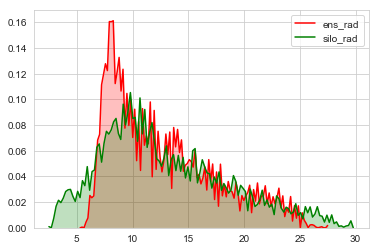

In [30]:
# this graph compares the densities of each unique value of a variable

sns.set_style('whitegrid')
ax = sns.kdeplot(eArrayVariable, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sArrayVariable, bw=0, color = 'green', shade = 'true')

In [ ]:
# this graph compares the densities of each unique value of a variable

sns.set_style('whitegrid')
ax = sns.kdeplot(eArrayVariable, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sArrayVariable, bw=0, color = 'green', shade = 'true')

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


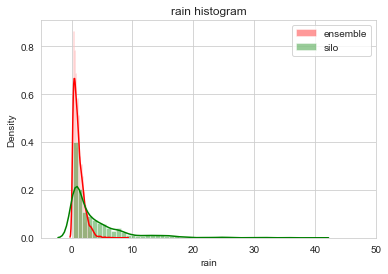

In [31]:
## rewrite the code to be able to use any of the variables in the datasets 

variable = "rain"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

if variable == "rain":
    eArray = [num for num in eArrayVariable if num > 0.1]
    sArray = [num for num in sArrayVariable if num > 0.1]
else:
    eArray = eArrayVariable
    sArray = sArrayVariable

fig, ax = plt.subplots()
sns.distplot(eArray, color="red", label = "ensemble")
sns.distplot(sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

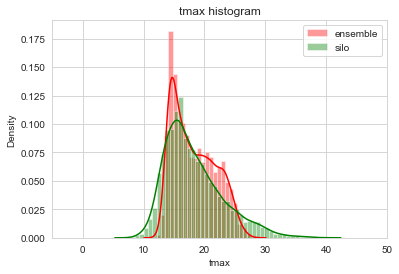

In [32]:
# run the code with a different variable

variable = "tmax"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

if variable == "rain":
    eArray = [num for num in eArrayVariable if num > 0.1]
    sArray = [num for num in sArrayVariable if num > 0.1]
else:
    eArray = eArrayVariable
    sArray = sArrayVariable

fig, ax = plt.subplots()
sns.distplot(eArray, color="red", label = "ensemble")
sns.distplot(sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

In [33]:
# Multiplicative bias - Answers the question: How does the average forecast magnitude 
# compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
variable = "tmax"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

bias = eArrayVariable.mean() / sArrayVariable.mean()
print (bias)


1.002039872651769


In [34]:
# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative

variable = "tmax"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

fcast_vs_obs["error"] = eArrayVariable - sArrayVariable
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

0.03716243450221683


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats


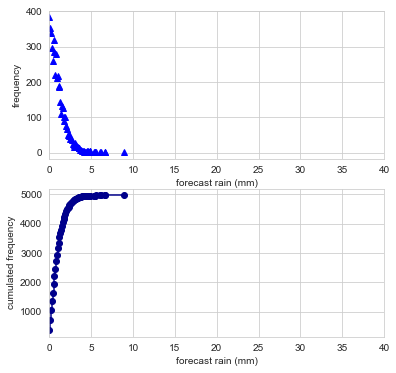

In [36]:
# frequency and accumulated frequency diagrams
variable = "rain"
eArrayVariable = fcast_vs_obs["ens_" + variable]
ensrainsorted = eArrayVariable.sort_values()

#values, freq = stats.itemfreq(ensrainsorted)
values, counts = np.unique(ensrainsorted, return_counts=True)
cum_freq = np.cumsum(counts)

fig, (ax1, ax2) = plt.subplots(2,1) #creates a fifure with a 2D axis

fig.set_size_inches(6,6)

ax1.set_xlim([0,40])
ax1.set_xlabel('forecast rain (mm)')
ax1.set_ylabel('frequency')
ax1.plot(values, counts, 'b^')
ax1.tick_params(axis='both', which = 'major')

ax2.set_xlim([0,40])
ax2.set_xlabel('forecast rain (mm)')
ax2.set_ylabel('cumulated frequency')
ax2.step(values, cum_freq, color = 'darkblue', marker = 'o', where = 'post')
ax2.tick_params(axis='both', which = 'major')


plt.show()
plt.close()

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotl

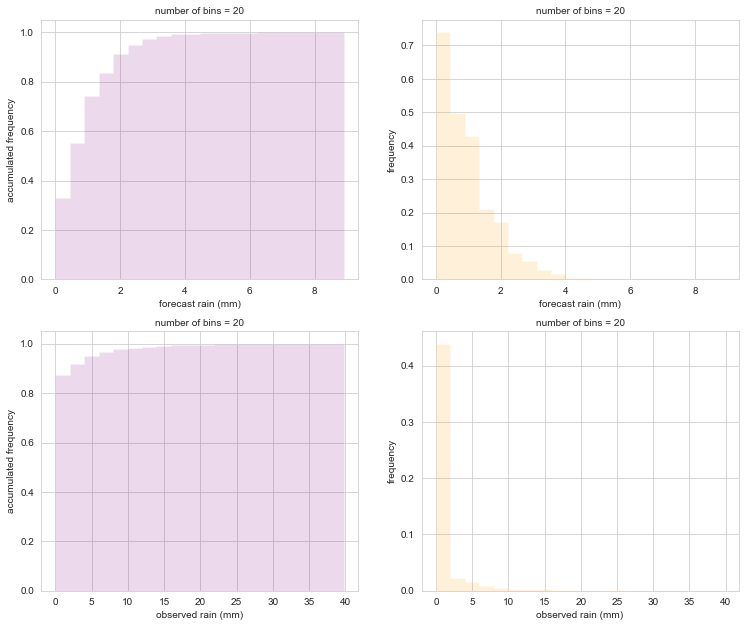

In [37]:
# Creating a multidimensional histogram
variable = "rain"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

ensrainsorted = eArrayVariable.sort_values()
silorainsorted = sArrayVariable.sort_values()

# create a figure with 4 axes (4 subplots) in a format of 2 x 2
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)

# size of the figure
fig.set_size_inches(12.5,10.5)

# 20 bins in the first subplot, normed histogram
n, bins, patches = ax1.hist(ensrainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = True, 
                            alpha = 0.15, color = 'purple')

ax1.set_xlabel('forecast rain (mm)')
ax1.set_ylabel('accumulated frequency')
ax1.set_title('number of bins = 20', fontsize = 10)

n, bins, patches = ax2.hist(ensrainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = False, 
                            alpha = 0.15, color = 'orange')

ax2.set_xlabel('forecast rain (mm)')
ax2.set_ylabel('frequency')
ax2.set_title('number of bins = 20', fontsize = 10)

n, bins, patches = ax3.hist(silorainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = True, 
                            alpha = 0.15, color = 'purple')

ax3.set_xlabel('observed rain (mm)')
ax3.set_ylabel('accumulated frequency')
ax3.set_title('number of bins = 20', fontsize = 10)

n, bins, patches = ax4.hist(silorainsorted, 20, normed = 1, 
                            histtype = 'stepfilled', cumulative = False, 
                            alpha = 0.15, color = 'orange')

ax4.set_xlabel('observed rain (mm)')
ax4.set_ylabel('frequency')
ax4.set_title('number of bins = 20', fontsize = 10)


plt.show()
plt.close()

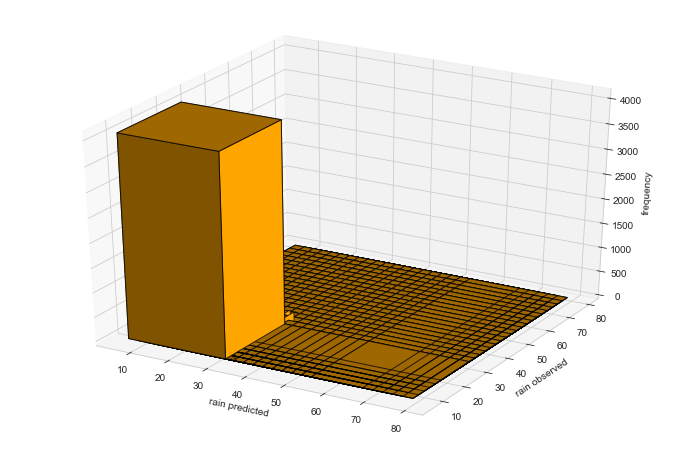

In [38]:
# histogram with two variables in matplotlib. 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create the histogram
# uses histogram2d from numpy
# need samples for both variables, number of bins, range of values

variable = "rain"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]


hist, xedge, yedge = np.histogram2d(eArrayVariable, sArrayVariable, bins = 20, range = [[0,50],[0,50]])

# draw the empty histogram

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111,projection='3d')


# add the inner workings

xpos, ypos = np.meshgrid(xedge[:-1] + 100/16, yedge[:-1] + 100/16)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

dx = 0.5 + np.ones_like(zpos) * 100/4
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color = ['orange'], zsort = 'average', alpha = 0.75, edgecolor = 'black')

ax.set_xlabel(variable + ' predicted')
ax.set_ylabel(variable + ' observed')
ax.set_zlabel('frequency')

plt.show()

Text(0.5, 1.0, '2D Gaussian Kernel density estimation of forecast versus observed tmax')

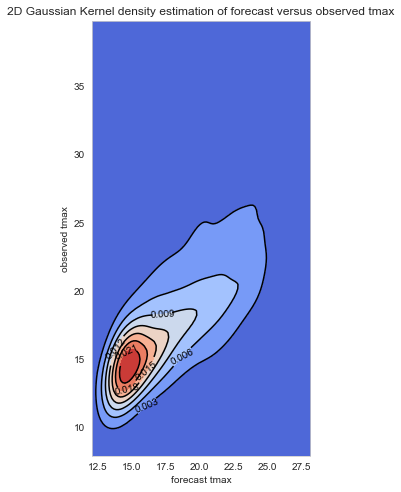

In [39]:
# bivariate diagrams: bidimensional Kernel Density Estimation
# The bivariate distribution needs the two mean values for the marginal distribution and the covariance matrix.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

variable = "tmax"
eArrayVariable = fcast_vs_obs["ens_" + variable]
sArrayVariable = fcast_vs_obs["silo_" + variable]

xmin = eArrayVariable.min()
xmax = eArrayVariable.max()
ymin = sArrayVariable.min()
ymax = sArrayVariable.max()

#Perform a kernel density estimate on the data:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

#We will fit a gaussian kernel using the scipy’s gaussian_kde method:
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([eArrayVariable, sArrayVariable])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)
#Plot the results:

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(X, Y, Z, cmap='coolwarm')
ax.imshow(np.rot90(Z), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(X, Y, Z, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('forecast ' + variable)
ax.set_ylabel('observed ' + variable)
plt.title('2D Gaussian Kernel density estimation of forecast versus observed ' + variable)



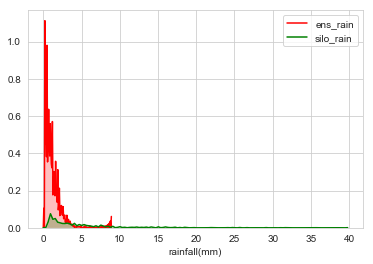

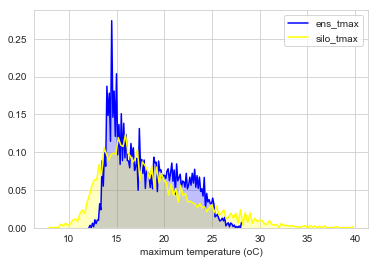

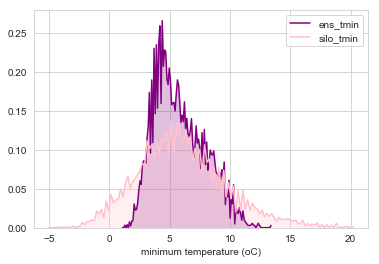

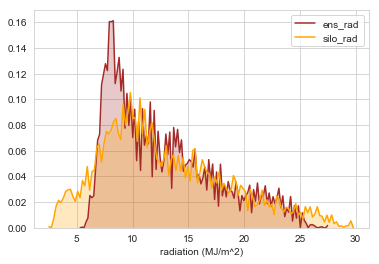

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sRain = fcast_vs_obs["silo_rain"]
eRain = fcast_vs_obs["ens_rain"]
sTMa = fcast_vs_obs["silo_tmax"]
eTMa = fcast_vs_obs["ens_tmax"]
sTMi = fcast_vs_obs["silo_tmin"]
eTMi = fcast_vs_obs["ens_tmin"]
sRad = fcast_vs_obs["silo_rad"]
eRad = fcast_vs_obs["ens_rad"]

sns.set_style('whitegrid')
ax1 = sns.kdeplot(eRain, bw=0, color = 'red', shade = 'true')
ax1 = sns.kdeplot(sRain, bw=0, color = 'green', shade = 'true')
plt.xlabel('rainfall(mm)')
plt.show()

sns.set_style('whitegrid')
ax2 = sns.kdeplot(eTMa, bw=0, color = 'blue', shade = 'true')
ax2 = sns.kdeplot(sTMa, bw=0, color = 'yellow', shade = 'true')
plt.xlabel('maximum temperature (oC)')
plt.show()

sns.set_style('whitegrid')
ax3 = sns.kdeplot(eTMi, bw=0, color = 'purple', shade = 'true')
ax3 = sns.kdeplot(sTMi, bw=0, color = 'pink', shade = 'true')
plt.xlabel('minimum temperature (oC)')
plt.show()

sns.set_style('whitegrid')
ax4 = sns.kdeplot(eRad, bw=0, color = 'brown', shade = 'true')
ax4 = sns.kdeplot(sRad, bw=0, color = 'orange', shade = 'true')
plt.xlabel('radiation (MJ/m^2)')
plt.show()

[Text(0.5, 0, 'maximum temperature (Celsius)')]

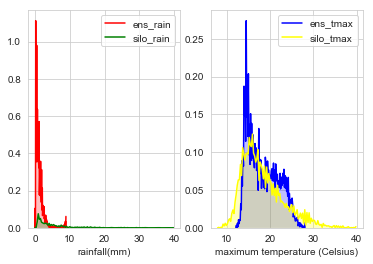

In [78]:
mport numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sRain = fcast_vs_obs["silo_rain"]
eRain = fcast_vs_obs["ens_rain"]
sTMa = fcast_vs_obs["silo_tmax"]
eTMa = fcast_vs_obs["ens_tmax"]
sTMi = fcast_vs_obs["silo_tmin"]
eTMi = fcast_vs_obs["ens_tmin"]
sRad = fcast_vs_obs["silo_rad"]
eRad = fcast_vs_obs["ens_rad"]

fig, ax=plt.subplots(1,2)
sns.set_style('whitegrid')
ax1 = sns.kdeplot(eRain, bw=0, color = 'red', shade = 'true', ax=ax[0])
ax1 = sns.kdeplot(sRain, bw=0, color = 'green', shade = 'true', ax=ax[0])
ax1.set(xlabel = 'rainfall(mm)')


sns.set_style('whitegrid')
ax2 = sns.kdeplot(eTMa, bw=0, color = 'blue', shade = 'true', ax=ax[1])
ax2 = sns.kdeplot(sTMa, bw=0, color = 'yellow', shade = 'true', ax=ax[1])
ax2.set(xlabel = 'maximum temperature (Celsius)')

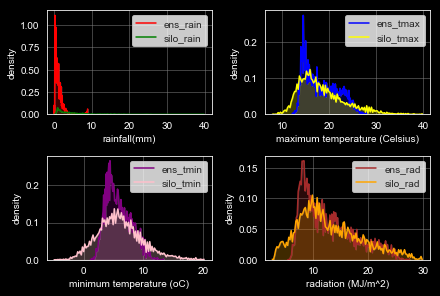

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

sRain = fcast_vs_obs["silo_rain"]
eRain = fcast_vs_obs["ens_rain"]
sTMa = fcast_vs_obs["silo_tmax"]
eTMa = fcast_vs_obs["ens_tmax"]
sTMi = fcast_vs_obs["silo_tmin"]
eTMi = fcast_vs_obs["ens_tmin"]
sRad = fcast_vs_obs["silo_rad"]
eRad = fcast_vs_obs["ens_rad"]

fig, ax = plt.subplots(2,2, constrained_layout = True)



sns.set_style('white')
ax1 = sns.kdeplot(eRain, bw=0, color = 'red', shade = 'true', ax=ax[0,0])
ax1 = sns.kdeplot(sRain, bw=0, color = 'green', shade = 'true', ax=ax[0,0])
ax1.set(xlabel = 'rainfall(mm)', ylabel = 'density')
ax1.grid(color='gray', linewidth=0.5)


sns.set_style('white')
ax2 = sns.kdeplot(eTMa, bw=0, color = 'blue', shade = 'true', ax=ax[0,1])
ax2 = sns.kdeplot(sTMa, bw=0, color = 'yellow', shade = 'true', ax=ax[0,1])
ax2.set(xlabel = 'maximum temperature (Celsius)', ylabel = 'density')
ax2.grid(color='gray', linewidth=0.5)

sns.set_style('white')
ax3 = sns.kdeplot(eTMi, bw=0, color = 'purple', shade = 'true', ax=ax[1,0])
ax3 = sns.kdeplot(sTMi, bw=0, color = 'pink', shade = 'true', ax=ax[1,0])
ax3.set(xlabel = 'minimum temperature (oC)', ylabel = 'density')
ax3.grid(color='gray', linewidth=0.5)

sns.set_style('white')
ax4 = sns.kdeplot(eRad, bw=0, color = 'brown', shade = 'true', ax=ax[1,1])
ax4 = sns.kdeplot(sRad, bw=0, color = 'orange', shade = 'true', ax=ax[1,1])
ax4.set(xlabel = 'radiation (MJ/m^2)', ylabel = 'density')
ax4.grid(color='gray', linewidth=0.5)
